# Setup

In [34]:
import json
import os
import sys

sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import ElasticNet, ElasticNetCV, LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, balanced_accuracy_score
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

from utils import read_csv_non_utf, preprocess_data, get_zero_nonzero_datasets, test_thresholds, ratios_to_DI_cats
from model_utils import HurdleModelEstimator
from plotting_utils import plot_ratio_confusion_matrix

In [2]:
# Loading in general configuration
with open('../config.json', 'r') as f:
    config = json.load(f)

# Getting filepaths
gdrive_fp = config['gdrive_path']
LIFE_fp = config['LIFE_folder']
dataset_fp = config['datasets_path']
benitez_lopez2019 = config['indiv_data_paths']['benitez_lopez2019']

data_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, benitez_lopez2019)

In [3]:
# Reading in data as a pandas dataframe
ben_lop2019 = read_csv_non_utf(data_path)
ben_lop2019.head()

,Reference,Study,Order,Family,Species,ratio,RR,X,Y,Region,Country,BM,Diet,DistKm,Reserve,TravTime,LivestockBio,Stunting,PopDens,Literacy
0,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.377193,-0.974594,9.839,-1.916,Africa,Gabon,17.07,Herb,0.05,No,755.8,39.25948,22.0,0.86,81.8
1,"Laurance et al., 2006",1,Proboscidea,Elephantidae,Loxodonta africana,0.865690,-0.144053,9.839,-1.916,Africa,Gabon,3940.03,Herb,0.05,No,755.8,39.25948,22.0,0.86,81.8
2,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.833333,-0.182139,9.839,-1.916,Africa,Gabon,17.07,Herb,0.30,No,755.8,39.25948,22.0,0.86,81.8
3,"Laurance et al., 2006",1,Proboscidea,Elephantidae,Loxodonta africana,0.900862,-0.104234,9.839,-1.916,Africa,Gabon,3940.03,Herb,0.30,No,755.8,39.25948,22.0,0.86,81.8
4,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.956140,-0.044691,9.839,-1.916,Africa,Gabon,17.07,Herb,0.60,No,755.8,39.25948,22.0,0.86,81.8


# Train/test split

For basic testing, we won't use cross validation--in this case, cross-validation is basically just multiple train/test splits anyways. We want to be sure to only use data statistics from the train set while preprocessing (e.g., for variable standardization).

In [4]:
# Establishing a shared train/test split
np.random.seed(1693)

idxs = np.arange(0, len(ben_lop2019))
np.random.shuffle(idxs)

train_size = 0.7
train_idxs = idxs[ : int(0.7 * len(idxs))]
test_idxs = idxs[int(0.7 * len(idxs)) : ]

idxs = {'train' : train_idxs, 'test' : test_idxs}

# Fixed effects hurdle model

I believe this will more accurately capture generalisation behavior, since we will not be able to make use of the random effects in the original mixed effects models--new species and countries will represent unseen levels on those categorical variables. See [this stackoverflow post](https://stackoverflow.com/questions/29259750/prediction-with-lme4-on-new-levels) for an explanation of `lme4`'s behavior with new levels.

Also, let's use all variables provided and either do our own feature selection or just depend on model regularization to do feature selection for us.

In [5]:
# Pre-processing data
pp_data = preprocess_data(ben_lop2019, include_indicators = True, standardize = True, log_trans_cont = False,
                          train_test_idxs = idxs)

# Train/test split
train_data, test_data = pp_data.loc[idxs['train']], pp_data.loc[idxs['test']]

In [6]:
# Defining sub-models for hurdle model
l1_ratio = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]
nonzero_model = ElasticNetCV(cv = 5, l1_ratio = l1_ratio, max_iter = 5000)
zero_model = LogisticRegressionCV(cv = 5, Cs = 20, penalty = 'l1', solver = 'saga', max_iter = 500)

hurdle_model = HurdleModelEstimator(zero_model, nonzero_model, extirp_pos = False, verbose = True)

In [7]:
# Fitting on the training data
hurdle_model.fit(train_data)

Fitting the nonzero model...


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2048474173042223, tolerance: 0.15963644969197596
  model = cd_fast.enet_coordinate_descent_gram(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.37572307266441385, tolerance: 0.15963644969197596
  model = cd_fast.enet_coordinate_descent_gram(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.64846067774522, tolerance: 0.15963644969197596
  model = cd_fast.enet_coordinate_descent

Fitting the zero model...


/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

HurdleModelEstimator(extirp_pos=False,
                     nonzero_model=ElasticNetCV(cv=5,
                                                l1_ratio=[0.1, 0.5, 0.7, 0.9,
                                                          0.95, 0.99, 1],
                                                max_iter=5000),
                     verbose=True,
                     zero_model=LogisticRegressionCV(Cs=20, cv=5, max_iter=500,
                                                     penalty='l1',
                                                     solver='saga'))

In [12]:
# Tuning the probability threshold for the classification model
X_zero, y_zero, _, _ = get_zero_nonzero_datasets(train_data, extirp_pos = False, pred = False)

y_pred_zero = hurdle_model.zero_model.predict_proba(X_zero)
y_pred_zero = y_pred_zero[ : , 1]
y_true_zero = y_zero

opt_thresh, metrics = test_thresholds(y_pred_zero, y_true_zero)
print(f'Best threshold was found to be {round(opt_thresh, 3)} with a TSS of {round(np.max(metrics["TSS"]), 3)}')

# Setting the threshold to the optimal in the hurdle model
hurdle_model.prob_thresh = round(opt_thresh, 3)

Best threshold was found to be 0.85 with a TSS of 0.604


In [15]:
# Predicting on the test set
pred_ratios = hurdle_model.predict(test_data)
test_ratios = test_data['ratio']

# Back-transforming to recover actual abundance ratios predicted by the hurdle model
pred_ratios[pred_ratios != 0] = np.exp(pred_ratios[pred_ratios != 0])
pred_DI_cats = ratios_to_DI_cats(pred_ratios)
true_DI_cats = ratios_to_DI_cats(test_ratios)

In [41]:
ratios_to_DI_cats(pp_data['ratio']).value_counts()

ratio
0.0    1766
2.0     784
1.0     731
Name: count, dtype: int64

## Model evaluation

In [21]:
# Calculatig metrics to match Benitez-Lopez
balanced_acc = balanced_accuracy_score(true_DI_cats, pred_DI_cats)
pseudo_r2 = np.corrcoef(pred_ratios, test_ratios)[0, 1] ** 2

print(f'Balanced accuracy: {round(balanced_acc * 100, 2)}%')
print(f'Pseudo-R^2: {round(pseudo_r2, 3)}')

Balanced accuracy: 52.63%
Pseudo-R^2: 0.037


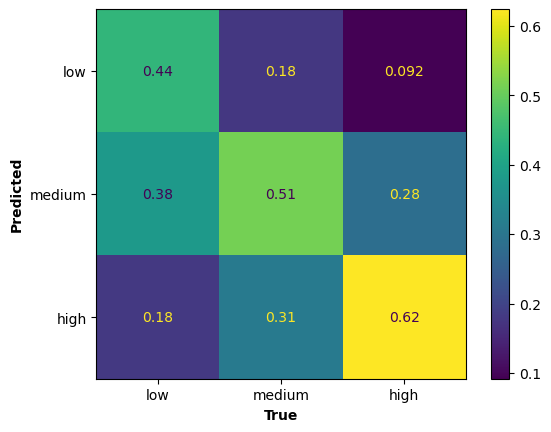

In [24]:
# Confusion matrix
fig, ax = plot_ratio_confusion_matrix(true_DI_cats, pred_DI_cats)

In [29]:
# Full report of classification relevant metrics based on HARD classifications
print(classification_report(true_DI_cats, pred_DI_cats, target_names = ['low', 'medium', 'high']))

              precision    recall  f1-score   support

         low       0.81      0.44      0.57       560
      medium       0.28      0.51      0.36       207
        high       0.45      0.62      0.52       218

    accuracy                           0.50       985
   macro avg       0.51      0.53      0.49       985
weighted avg       0.62      0.50      0.52       985



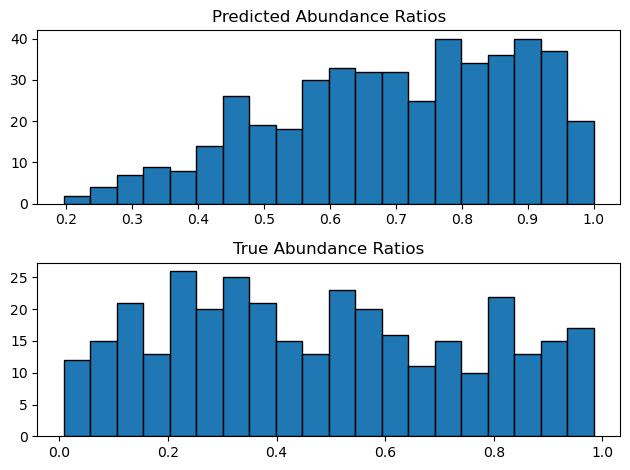

In [32]:
# Comparing the distribution of abundance ratios in the 0-1 range...
fig, ax = plt.subplots(2)

pred_ratios_0_1 = pred_ratios[(pred_ratios < 1) & (pred_ratios > 0)]
ax[0].hist(pred_ratios_0_1, edgecolor = 'black', bins = 20)
ax[0].set_title('Predicted Abundance Ratios')

true_ratios_0_1 = test_ratios[(test_ratios < 1) & (test_ratios > 0)]
ax[1].hist(true_ratios_0_1, edgecolor = 'black', bins = 20)
ax[1].set_title('True Abundance Ratios')

fig.tight_layout()

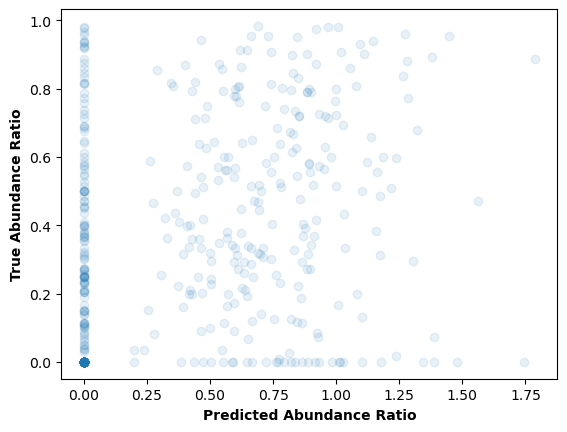

In [33]:
# Regression results, abundance ratio
threshold_mask = test_ratios < 1

plt.scatter(pred_ratios[threshold_mask], test_ratios[threshold_mask], alpha = 0.1)

plt.xlabel('Predicted Abundance Ratio', weight = 'bold')
plt.ylabel('True Abundance Ratio', weight = 'bold');

# Random forest